   # Aditya Birla Capital - Analyst assignment

## Objective:
1. Perform EDA on the data set provided.
2. Problem statement - Business needs to understand the performance of the portfolio by various segments.
3. Propose to policy team few key parameters to be used for filtering the bad loans. Provide the reasoning for selecting the variable.

## Assumptions:
1. The original data set contains approx. 9 Lakhs entries which was making system very slow to perform any kind of operation.
2. Therefore I have consider the data where the term (Variable from dataset lc_loan) is of  60 months which was 30% of the original data.

In [1]:
### Importing Required Libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import os
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
## Importing data:

train = pd.read_csv("C:/Users/Training 12/Desktop/kaggle/lc_loan_new.csv")

In [ ]:
train.columns

In [4]:
train.shape

(266254, 74)

In [5]:
## Findig missing values percentage wise:

percentage = train.isnull().sum() *100/len(train)
percentage.sort_values(ascending = False)

dti_joint                      99.898217
annual_inc_joint               99.897842
verification_status_joint      99.897842
il_util                        97.839281
mths_since_rcnt_il             97.619191
inq_last_12m                   97.582759
total_cu_tl                    97.582759
open_acc_6m                    97.582759
open_il_6m                     97.582759
open_il_12m                    97.582759
open_il_24m                    97.582759
total_bal_il                   97.582759
open_rv_12m                    97.582759
open_rv_24m                    97.582759
max_bal_bc                     97.582759
all_util                       97.582759
inq_fi                         97.582759
desc                           89.116408
mths_since_last_record         86.261615
mths_since_last_major_derog    76.106274
mths_since_last_delinq         51.362609
next_pymnt_d                   21.150105
total_rev_hi_lim               10.738242
tot_cur_bal                     6.081411
tot_coll_amt    

##### As some of the  columns have missing values over 75%, I have removed that columns.

In [6]:
## setting threshold for deleting columns:

thresh = len(train) * 0.3
thresh

79876.2

In [7]:
train.dropna(thresh = thresh, axis = 1, inplace = True)

In [8]:
train.shape

(266254, 54)

In [ ]:
percentage = train.isnull().sum() *100/len(train)
percentage.sort_values(ascending = False)

In [ ]:
train.sample(5)

In [9]:
## printing no. of unique count for id and Member_id for checking any duplicate entry:

print(train['member_id'].nunique() ,train['id'].nunique())

266254 266254


In [10]:
## since member id and id have same unique values so we can drop either of the the two column.

train.drop(['member_id','url','zip_code','policy_code','emp_title','title'], axis = 1, inplace = True )

In [ ]:
train.head()

In [11]:
## converting date columns in datetime format:

train['issue_year'] = pd.to_datetime(train['issue_d'], format = '%b-%y').dt.year
train['issue_d'] = pd.to_datetime(train['issue_d'], format = '%b-%y').dt.to_period('M')
train['earliest_cr_line'] = pd.to_datetime(train['earliest_cr_line'], format = '%b-%y').dt.to_period('M')
train['last_pymnt_d'] = pd.to_datetime(train['last_pymnt_d'], format = '%b-%y').dt.to_period('M')
train['next_pymnt_d'] = pd.to_datetime(train['next_pymnt_d'], format = '%b-%y').dt.to_period('M')
train['last_credit_pull_d'] = pd.to_datetime(train['last_credit_pull_d'], format = '%b-%y').dt.to_period('M')

### Understanding of Objective variables (Univariate Analysis) :

In [12]:
object_col = []

for column in train.columns:
    if train[column].dtype == object and len(train[column].unique()) <=50:
        object_col.append(column)
        print (f"{column} : {train[column].nunique()}")
        print (f"{column} : {train[column].unique()}")
        print (train[column].value_counts(dropna = False, ascending = False, normalize = True))
        print ("===============================================================================")


term : 1
term : [' 60 months']
 60 months    1.0
Name: term, dtype: float64
grade : 7
grade : ['C' 'B' 'F' 'D' 'E' 'G' 'A']
C    0.313385
D    0.236072
E    0.183520
B    0.159720
F    0.069783
A    0.019481
G    0.018039
Name: grade, dtype: float64
sub_grade : 34
sub_grade : ['C4' 'B5' 'C5' 'F2' 'C3' 'D2' 'E4' 'D3' 'B2' 'D4' 'F3' 'E3' 'F4' 'B3'
 'F1' 'C1' 'E5' 'B1' 'G4' 'E1' 'B4' 'E2' 'A4' 'D5' 'A5' 'C2' 'G3' 'G2'
 'G1' 'F5' 'G5' 'D1' 'A3' 'A2']
C4    0.077325
C3    0.066959
C5    0.061674
C2    0.057982
D1    0.054981
D4    0.049802
C1    0.049445
D2    0.044766
B4    0.044349
D5    0.044304
E1    0.042895
E2    0.042794
D3    0.042219
B3    0.037727
E3    0.037720
E4    0.033115
B5    0.029874
E5    0.026997
B1    0.023951
B2    0.023819
F1    0.021055
F2    0.016616
A5    0.016019
F3    0.013025
F4    0.010704
F5    0.008383
G1    0.006118
G2    0.004571
G3    0.003313
A4    0.003256
G4    0.002160
G5    0.001878
A3    0.000154
A2    0.000053
Name: sub_grade, dtype: float64
emp_len

### Observations from above output:
1. Terms we have consider is of 60 Months.
2. Grade C and D contains 50% of the Data out of 7 Grades.
3. There are 34 unique sub_grade Category.
4. There are 105987 unique Emp_title Category.
5. 58% customer's having Mortgage Ownership.
6. Major purpose of taking loan is for Debit_consolidation(~65%).
7. There are 49 states.
8. Most of Individuals(~99%) have applied for the loan.
9. There are 10 unique category of Loan Status in which Current have 74% observations.

### Understing loan application trend  over the years.

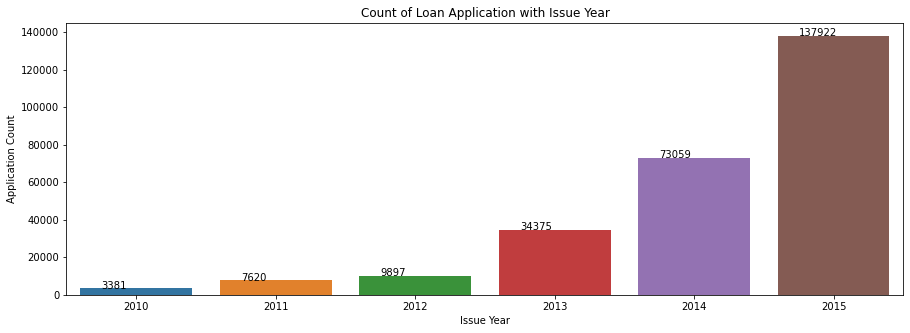

In [13]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'issue_year', data = train )
plt.title('Count of Loan Application with Issue Year')
plt.xlabel('Issue Year')
plt.ylabel('Application Count')

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


### From above graph, we can see that Count of Loan application in increasing YoY.

## Understanding of Numerical Variables:

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'mths_since_last_delinq'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'out_prncp'}>,
        <AxesSubplot:title={'center':'out_prncp_inv'}>],
       [<AxesSubplot:title={'center':'tota

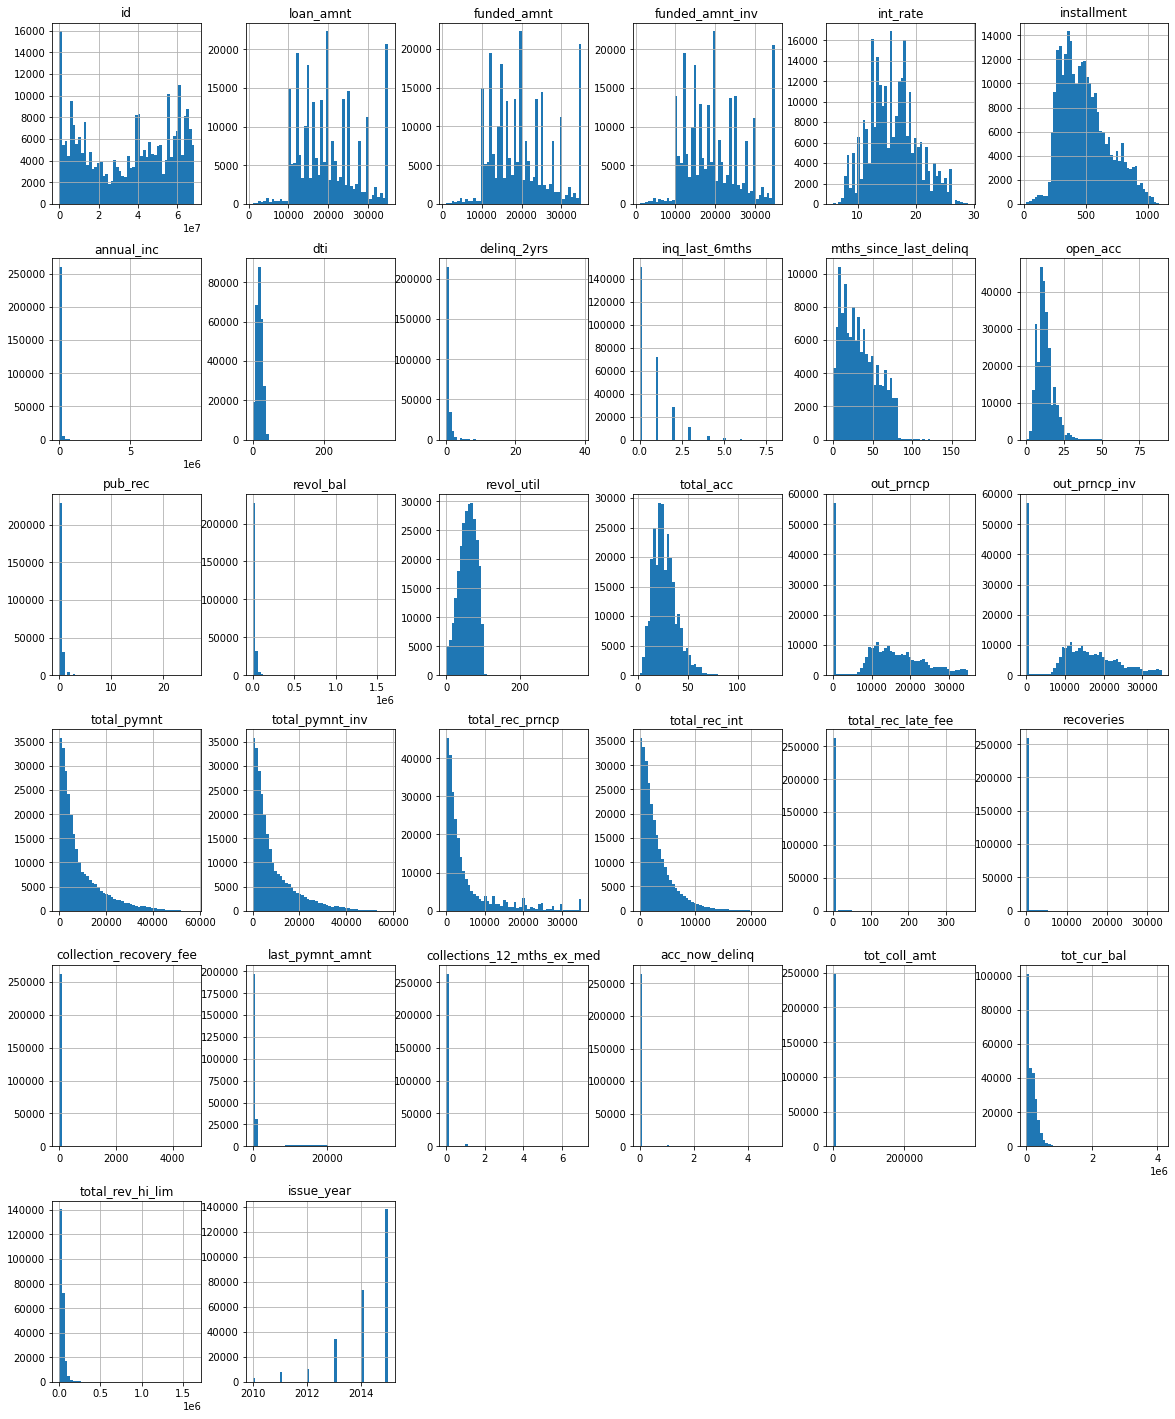

In [14]:
train.hist(bins=50, figsize=(20, 25))

### Observations from above output:
1. Loan amount, Funded amount and Funded_amount_individuals have same pattern.
2. Total payment and total payment_ind also have same pattern.
3. Simillarly for out_prncp and out_prncp_inv. have same pattern.
4. Most of the loan amount lies between 10000 to 20000.
5. The maximum applicants having interest rate percentage between 10% to 20%.


In [ ]:
train.head()

In [15]:
pd.set_option('float_format', '{:.2f}'.format)

In [16]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,266254.00,34854776.24,22163696.41,66128.00,12565376.75,38558922.00,55758445.75,68617057.00
loan_amnt,266254.00,20059.81,7464.59,1000.00,14400.00,19425.00,25000.00,35000.00
funded_amnt,266254.00,20030.61,7463.35,1000.00,14375.00,19325.00,25000.00,35000.00
funded_amnt_inv,266254.00,20007.11,7462.29,950.00,14325.00,19250.00,25000.00,35000.00
int_rate,266254.00,16.11,4.20,5.79,13.18,15.61,18.79,28.99
installment,266254.00,490.79,194.05,19.87,340.22,461.06,607.62,1110.76
annual_inc,266254.00,80794.60,60422.80,4800.00,52000.00,70000.00,95000.00,9500000.00
dti,266254.00,19.50,8.32,0.00,13.36,19.10,25.32,380.53
delinq_2yrs,266254.00,0.31,0.85,0.00,0.00,0.00,0.00,39.00
inq_last_6mths,266254.00,0.69,0.98,0.00,0.00,0.00,1.00,8.00


In [ ]:
train.info()

### let's bifurcate Loan Status in Good Loans / Non-Default (assign : 0) and Bad Loans / Default (assign : 1)

In [20]:
train['loan_status'].value_counts()

Current                                                198931
Fully Paid                                              40148
Charged Off                                             16165
Late (31-120 days)                                       4565
Issued                                                   2478
In Grace Period                                          2278
Late (16-30 days)                                         874
Default                                                   504
Does not meet the credit policy. Status:Fully Paid        199
Does not meet the credit policy. Status:Charged Off       112
Name: loan_status, dtype: int64

In [21]:
loan_status_mapping = {
    'Current': 0,
    'Fully Paid':0,
    'Issued':0,
    'Charged Off': 1,
    'Late (31-120 days)': 1,
    'In Grace Period': 1,
    'Late (16-30 days)':1,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Default':1,
    'Does not meet the credit policy. Status:Charged Off' : 1
}

In [22]:
train['Loan_status_dummy'] = train['loan_status'].map(loan_status_mapping)

In [23]:
train['Loan_status_dummy'] = train['Loan_status_dummy'].astype('str')

In [24]:
train['Loan_status_dummy'].value_counts(normalize = True)

0   0.91
1   0.09
Name: Loan_status_dummy, dtype: float64

### From above output, we can say that there are 9% of customers who falls under bad loan category (Default)

## Lets do Bivaritate analysis with Loan Status:

###  Lets check Grade and Loan Status combination :

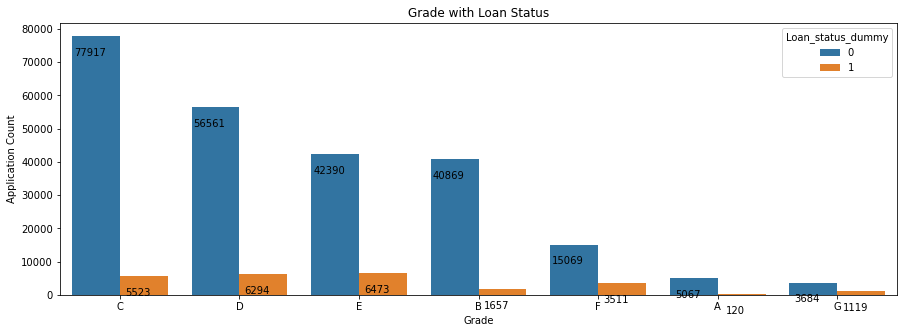

In [89]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'grade', hue = 'Loan_status_dummy', data = train,  order=train['grade'].value_counts().index)
plt.title('Grade with Loan Status')
plt.xlabel('Grade')
plt.ylabel('Application Count')


for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.15, p.get_height()+ 50), ha = 'center', va= 'top')

#### From above graph, we can see that D and E grade Customer have more numbers of Defaulters. 

### Lets check Emp Length and Loan Status combination: 

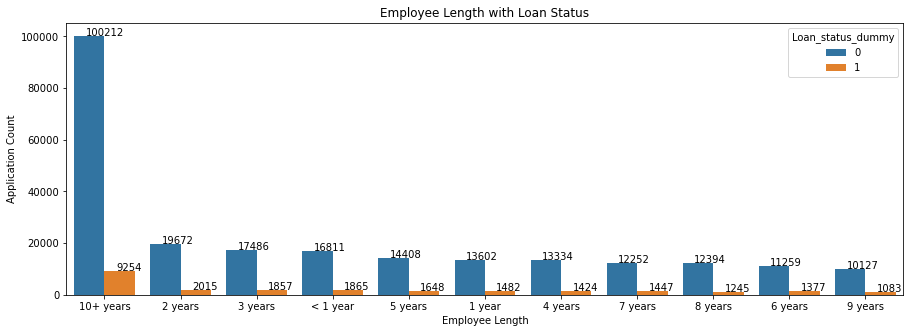

In [87]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'emp_length', hue = 'Loan_status_dummy', data = train, order=train['emp_length'].value_counts().index )
plt.title('Employee Length with Loan Status')
plt.xlabel('Employee Length')
plt.ylabel('Application Count')

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


#### From above graph, we can see that customer having empl_lenth is 10+Years has more no. of Default customers.

### Lets check Home Owndership and Loan Status combination:

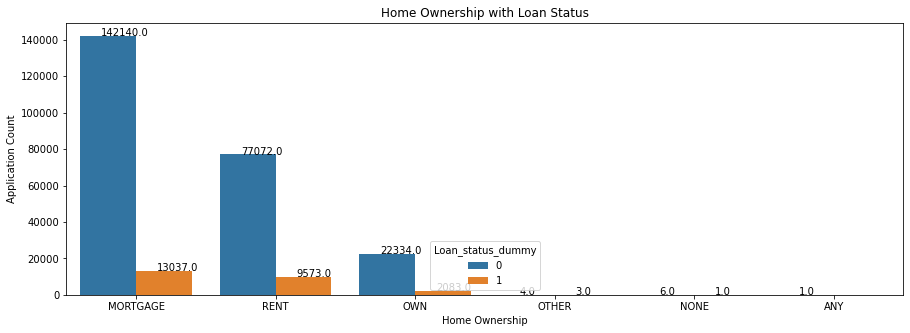

In [27]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'home_ownership', hue = 'Loan_status_dummy', data = train, order=train['home_ownership'].value_counts().index )
plt.title('Home Ownership with Loan Status')
plt.xlabel('Home Ownership')
plt.ylabel('Application Count')


for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


### Lets check Purpose and Loan Status combination:

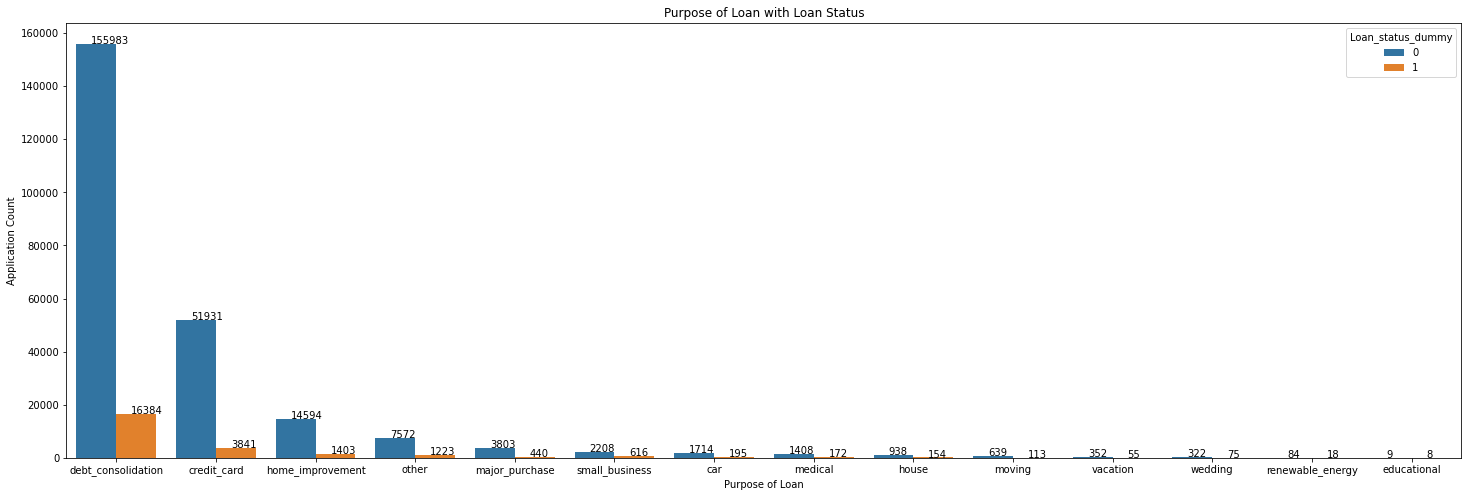

In [28]:
plt.figure(figsize = (25,8))
ax = sns.countplot(x = 'purpose', hue = 'Loan_status_dummy', data = train, order=train['purpose'].value_counts().index )
plt.title('Purpose of Loan with Loan Status')
plt.xlabel('Purpose of Loan')
plt.ylabel('Application Count')



for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


#### From the above graph, Most defaulters are from Debt_consolidation.

### Lets check State and Loan Status combination: 

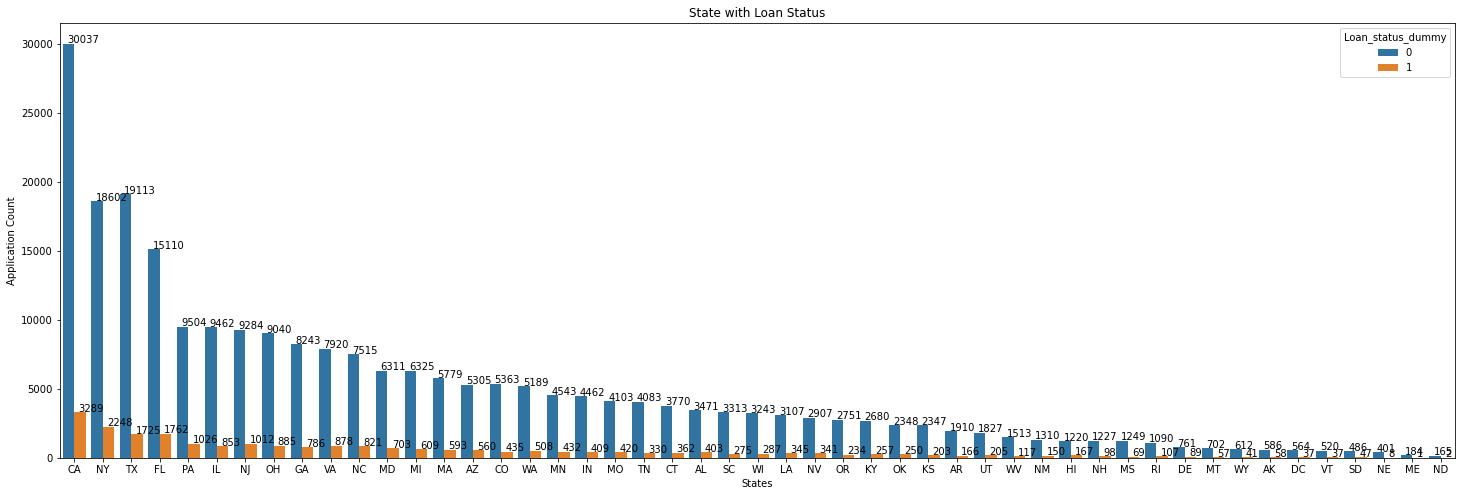

In [29]:
plt.figure(figsize = (25,8))
ax = sns.countplot(x = 'addr_state', hue = 'Loan_status_dummy', data = train, order=train['addr_state'].value_counts().index )
plt.title('State with Loan Status')
plt.xlabel('States')
plt.ylabel('Application Count')


for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


#### CA and NY has more no. of defaulters and applicants as well.

### Lets check Varification Status and Loan Status combination: 

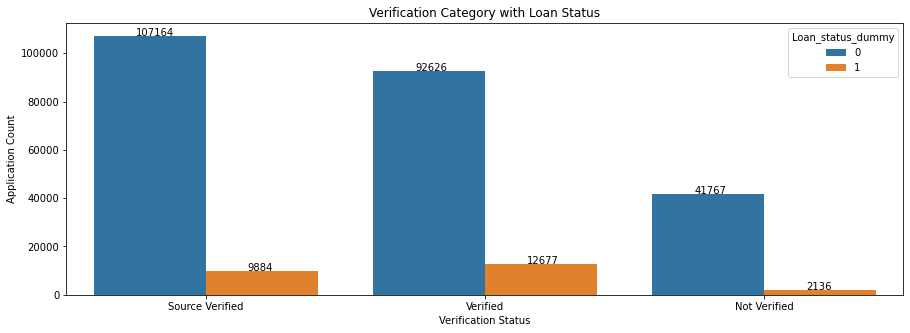

In [30]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'verification_status', hue = 'Loan_status_dummy', data = train, order=train['verification_status'].value_counts().index )
plt.title('Verification Category with Loan Status')
plt.xlabel('Verification Status')
plt.ylabel('Application Count')


for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


#### Although, the count of Source verified is high  but the major Defaulters are from Verified backgroud.

### Lets check Loan Issue Year and Loan Status combination: 

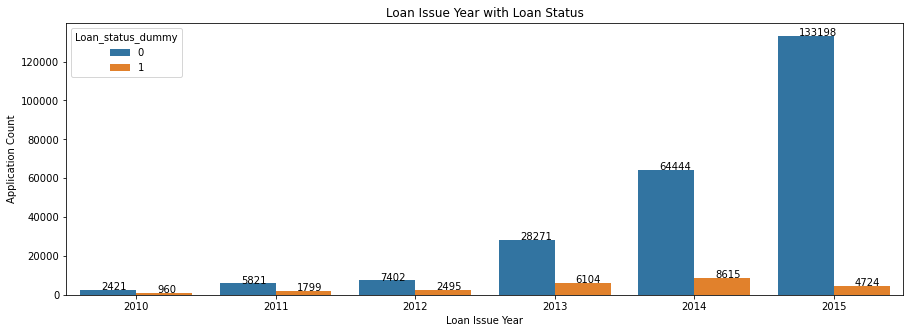

In [31]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'issue_year', hue = 'Loan_status_dummy', data = train )
plt.title('Loan Issue Year with Loan Status')
plt.xlabel('Loan Issue Year')
plt.ylabel('Application Count')


for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


#### The no. of defaulters for 2015 is nearly 50% descreased as compared with 2014.

## Lets categories Loan amount into 3 segment and check the loan_Status:

In [32]:
train['Loan_Category'] = np.where(train['loan_amnt'] <= 10000, "Low",
                                 np.where(train['loan_amnt'] <= 20000, "Medium","High"))

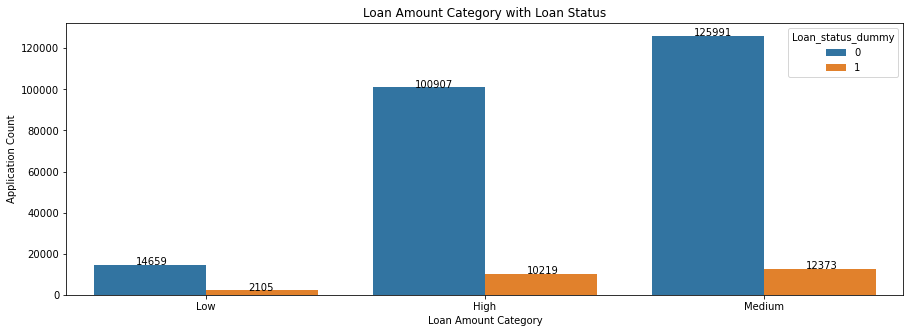

In [33]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'Loan_Category', hue = 'Loan_status_dummy', data = train )
plt.title('Loan Amount Category with Loan Status')
plt.xlabel('Loan Amount Category')
plt.ylabel('Application Count')

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


#### From above graph, we can say that most of the defaulters are from Medium and High Loan category.

### Lets categories Income amount into 3 segment and check the loan_Status:

In [34]:
train['Income_Category'] = np.where(train['annual_inc'] <= 100000, "Low",
                                 np.where(train['annual_inc'] <= 300000, "Medium","High"))

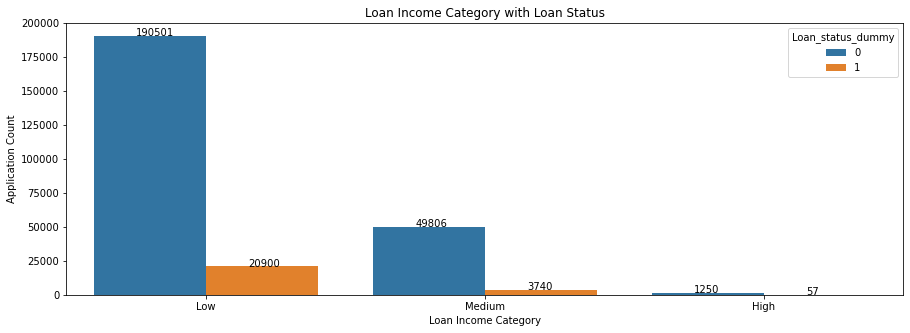

In [35]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'Income_Category', hue = 'Loan_status_dummy', data = train )
plt.title('Loan Income Category with Loan Status')
plt.xlabel('Loan Income Category')
plt.ylabel('Application Count')

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


### Most of the loan applicant are from those customer who is having annual income less than 1 lakh.

#### Lets categories Interest Rate into 3 segment and check the loan_Status:

In [36]:
train['Interest_rate_Category'] = np.where(train['int_rate'] <= 10, "Low",
                                 np.where(train['int_rate'] <= 20, "Medium","High"))

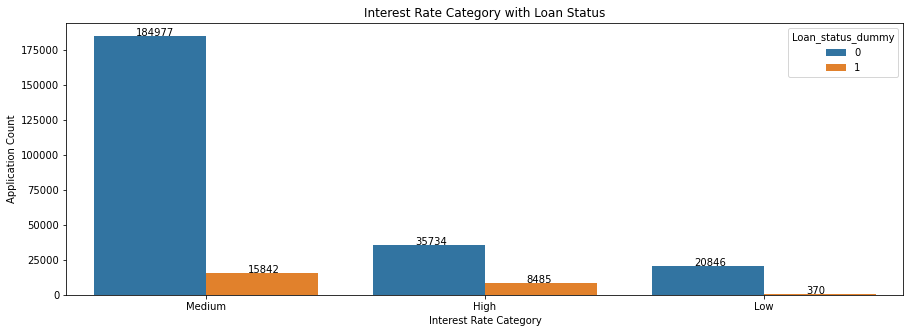

In [37]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'Interest_rate_Category', hue = 'Loan_status_dummy', data = train )
plt.title('Interest Rate Category with Loan Status')
plt.xlabel('Interest Rate Category')
plt.ylabel('Application Count')

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.15, p.get_height()+50))


### Major defaulter are from medium range category with interest rate between 10% to 20%.

### Some Key take away from above Bivariate analysis from Defaulter's view:
1. Employee length 10+ have high tendency in coming defaluter's criteria.
2. Those customers who have  mortgage ownership have high chances of defaulters.
3. Those customers who takes the loan for Debit_consolidation have more chances of  getting  default.
4. Verified status customers tends to go defaulters.
5. Higher the loan amount, higher the chances of defaulters.
6. Moderate interest rate (i.e From 10% to 20%) have high default customers.

#### To get more insights from each variables, I would like to introduces new package called Dtale.
You can run below query for more  understanding for EDA.

In [ ]:
## Installing Library:

# !pip install dtale

In [38]:
import dtale
dtale.show(train)

### Missing Value Treatment: 

In [39]:
train.isnull().sum().sort_values(ascending = False)

mths_since_last_delinq        136755
next_pymnt_d                   56313
total_rev_hi_lim               28591
tot_coll_amt                   16192
tot_cur_bal                    16192
emp_length                      8659
last_pymnt_d                    5379
revol_util                       116
last_credit_pull_d                11
term                               0
verification_status                0
earliest_cr_line                   0
delinq_2yrs                        0
dti                                0
addr_state                         0
purpose                            0
pymnt_plan                         0
loan_status                        0
issue_d                            0
annual_inc                         0
int_rate                           0
home_ownership                     0
loan_amnt                          0
sub_grade                          0
funded_amnt                        0
grade                              0
funded_amnt_inv                    0
i

In [40]:
train.drop(['mths_since_last_delinq','next_pymnt_d','last_pymnt_d','last_credit_pull_d'], axis = 1, inplace = True)

In [41]:
## Replacing Missing values by 0:

train['total_rev_hi_lim'] = train['total_rev_hi_lim'].fillna(0)
train['tot_cur_bal'] = train['tot_cur_bal'].fillna(0)
train['tot_coll_amt'] = train['tot_coll_amt'].fillna(0)
train['revol_util'] = train['revol_util'].fillna(0)
train['emp_length'] = train['emp_length'].fillna('10+ years')

### We have replaced all the missing  value with 0 and  deleted all columns wich contains date.

### Let's check the correlation between all numberical variables:

<AxesSubplot:>

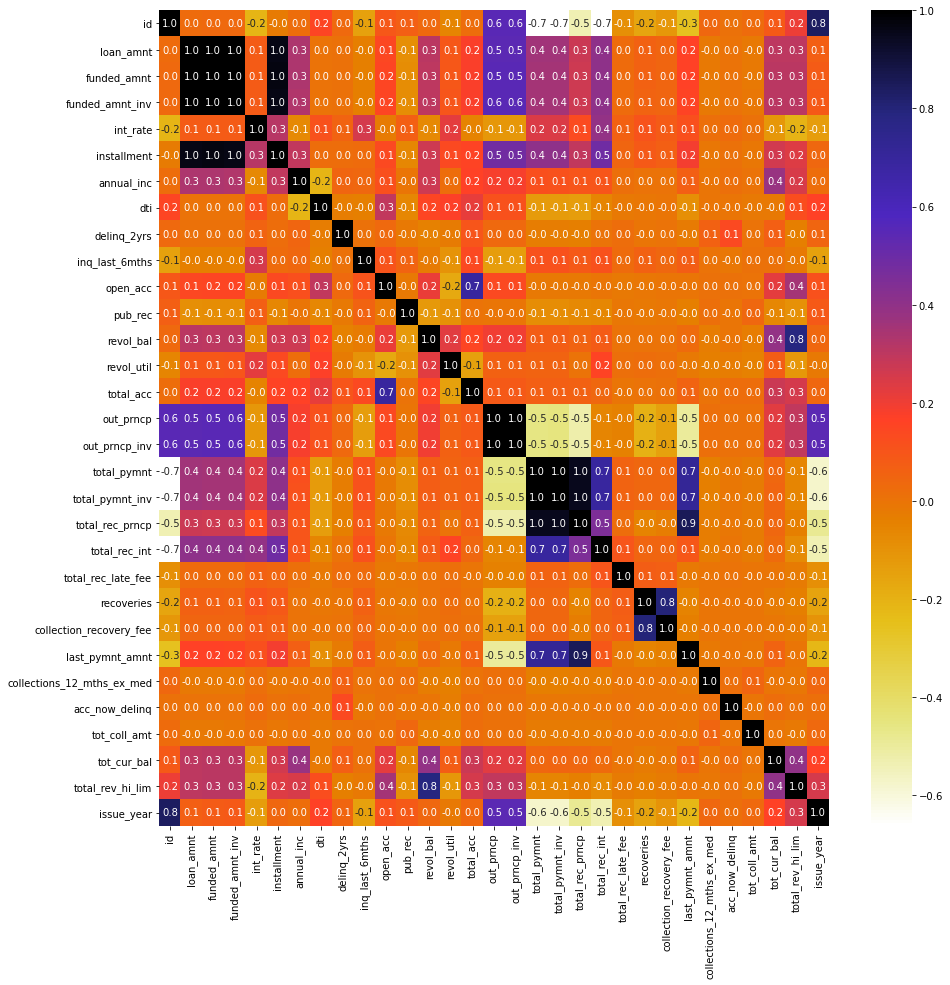

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(),annot=True,fmt=".1f",cmap=plt.cm.CMRmap_r)

In [43]:

def correlation(train, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [44]:
corr_features = correlation(train, 0.7)
len(set(corr_features))

10

In [45]:
# Idetify the variables which having higher correlation with other variables:

corr_features

{'collection_recovery_fee',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'issue_year',
 'last_pymnt_amnt',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rev_hi_lim'}

In [46]:
train.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'issue_year',
       'Loan_status_dummy', 'Loan_Category', 'Income_Category',
       'Interest_rate_Category'],
      dtype='object')

In [47]:
## Creating dataframe model building:

X=train.drop(['id','loan_status','Loan_status_dummy','collection_recovery_fee','funded_amnt','funded_amnt_inv','installment',
              'issue_year','last_pymnt_amnt','out_prncp_inv','total_pymnt_inv','total_rec_prncp','total_rev_hi_lim',
             'loan_amnt','annual_inc','int_rate','issue_d', 'earliest_cr_line','term','pymnt_plan','application_type'],axis=1)
y=train['Loan_status_dummy']


In [48]:
## For categorical variables:

cat_columns = []
for col in X.select_dtypes('object').columns:
    print(col)
    cat_columns.append(col)
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

grade
sub_grade
emp_length
home_ownership
verification_status
purpose
addr_state
initial_list_status
Loan_Category
Income_Category
Interest_rate_Category


In [49]:
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index

[0, 1, 2, 3, 4, 5, 6, 15, 25, 26, 27]

In [50]:
# Train_ test split:

X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=1234, 
                                                       stratify=y)

### Performing LIGHTGBM:

In [67]:
NUM_OF_BOOST_ROUND = 1000
EARLY_STOPPING = 300

In [68]:
params = {
    'cat_features' : cat_features_index,
    'metric': 'auc',
    'seed': 1234,
    'n_estimators': NUM_OF_BOOST_ROUND
}

In [69]:
clf = lgb.LGBMClassifier(**params)

In [86]:
clf.fit(X_train, y_train, eval_set=(X_valid, y_valid),early_stopping_rounds=100, verbose=-1)

[LightGBM] [Warning] Unknown parameter: cat_features
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's auc: 0.919687


LGBMClassifier(cat_features=[0, 1, 2, 3, 4, 5, 6, 15, 25, 26, 27], metric='auc',
               n_estimators=1000, seed=1234)

In [71]:
ypred_lgb = clf.predict_proba(X_valid)[:,1]

In [72]:
ypred_lgb

array([0.02546473, 0.07684491, 0.97782478, ..., 0.05475309, 0.0066172 ,
       0.05252909])

In [73]:
roc_auc_score(y_valid, ypred_lgb)

0.9196867749451069

<AxesSubplot:>

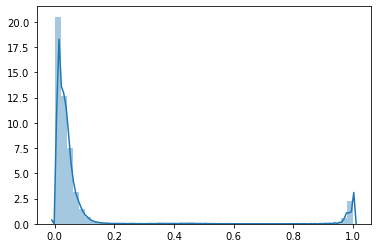

In [74]:
sns.distplot(ypred_lgb)

In [75]:
f_importance_df = pd.DataFrame(clf.feature_importances_, columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

<AxesSubplot:xlabel='importance'>

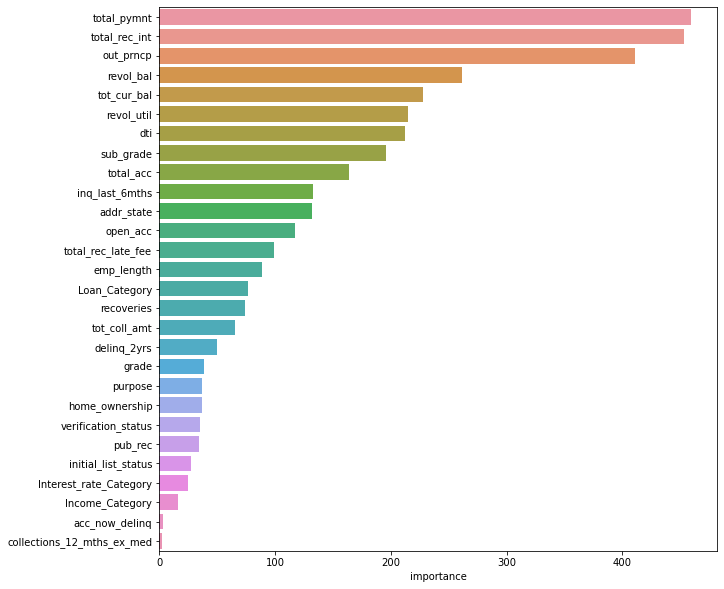

In [76]:
plt.figure(figsize=(10,10))
sns.barplot(x=f_importance_df.importance, y=f_importance_df.index)


### The ROC Score is 92%.
### From our model, Total payment, Total_rec_int, Out_prncp, revol_bal, Total_cur_bal these are the major important variables for identifying defaulters.

### Performing CatBOOST :

In [77]:
params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': 1234,
    'n_estimators': NUM_OF_BOOST_ROUND,
}

In [78]:
bst = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
_ = bst.fit(X_train, y_train, eval_set=(X_valid,y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [79]:
ypred_cat = bst.predict_proba(X_valid)[:,1]

In [80]:
ypred_cat

array([0.03065545, 0.03410979, 0.98598097, ..., 0.05439967, 0.00708076,
       0.05245022])

In [81]:
roc_auc_score(y_valid, ypred_cat)

0.9193946994532166

<AxesSubplot:>

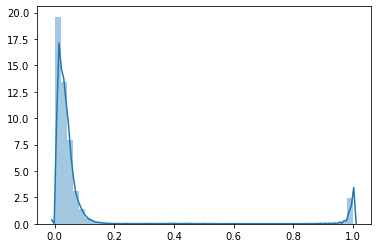

In [82]:
sns.distplot(ypred_cat)

In [83]:
f_importance_df = pd.DataFrame(bst.get_feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

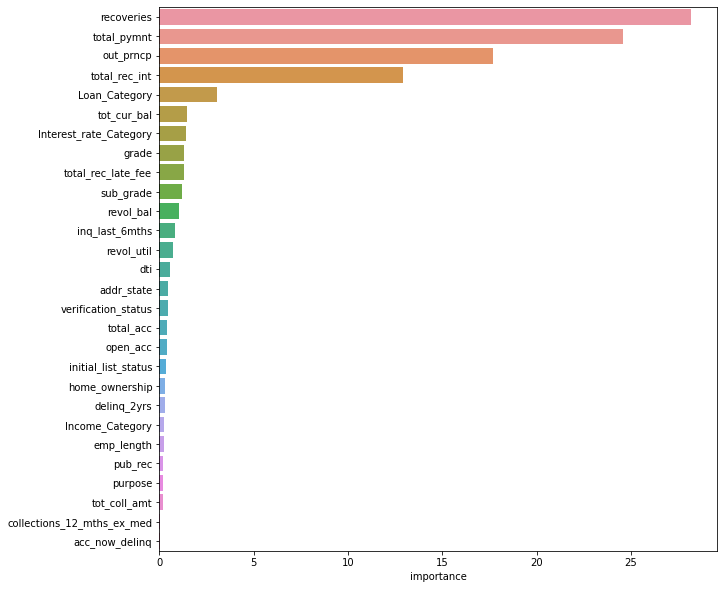

In [84]:
plt.figure(figsize=(10,10))
sns.barplot(x=f_importance_df.importance, y=f_importance_df.index);

### The ROC Score is 92%.
### From our model, Total payment, Total_rec_int, Out_prncp, recoveries, Total_cur_bal these are the major important variables for identifying defaulters.

### Reason for considering LightGBM and CatBoost:
1. Due to time constrain I directly moved to Lightgbm and catboost as both the models performed in quick time.
2. Since our data have majority of categorical variables, Lightgbm and Catboost handles categorical variables very well. So we 
dont required to do label encoding, mean encoding, frequency encoding etc. on categorical variables.
3. Since, the data is imbalanced therefore I have  considered ROC_AUC_Curve for evaluation matrix.